In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle
%matplotlib inline
plt.rcParams['figure.dpi'] = 200

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [90]:
from model_exp.model import get_model
from genetic_algorithm import mono_objective as mono_GA

In [5]:
from audio_features.features import Features

In [6]:
import pandas as pd

In [7]:
backup_folder = os.path.join("data", "level_selection_simulations")

In [10]:
from experiments.simulations import *

In [11]:
from experiments.analysis import *

In [12]:
from experiments.plots import *

In [14]:
from scipy.stats import shapiro

# Simulations

Get color cycle

In [15]:
cycle = plt.rcParams['axes.prop_cycle'].by_key()['color'] + ['b', 'g', 'r', 'c', 'm', 'y', 'k']

## Unpleasantness N1 case

In [39]:
nb_runs = 50
sim_model = "UnpLin"
pred_model = "UnpLinExc"
n_tokeep_list = [4, 3, 2]

In [40]:
name_list = ["Initial", "Model", "Loudness", "Roughness"]
features_list = [None, pred_model, "N_BS", "R_BSmean"]
minmax_list = [None, "min", "min", "min"]

Make simulations

In [ ]:
data_min, data_mean = run_fifty_fifty_mean(sim_model, n_tokeep_list, nb_runs, features_list, name_list, minmax_list)

Save simulation data

In [42]:
with open(os.path.join(backup_folder, 'unp_N1_mean_mean.pickle'), 'wb') as f:
    pickle.dump(data_mean, f)
with open(os.path.join(backup_folder, 'unp_N1_min_mean.pickle'), 'wb') as f:
    pickle.dump(data_min, f)

Load simulation data

In [68]:
with open(os.path.join(backup_folder, 'unp_N1_mean_mean.pickle'), 'rb') as f:
    data_mean = pickle.load(f)
with open(os.path.join(backup_folder, 'unp_N1_min_mean.pickle'), 'rb') as f:
    data_min = pickle.load(f)

Plot

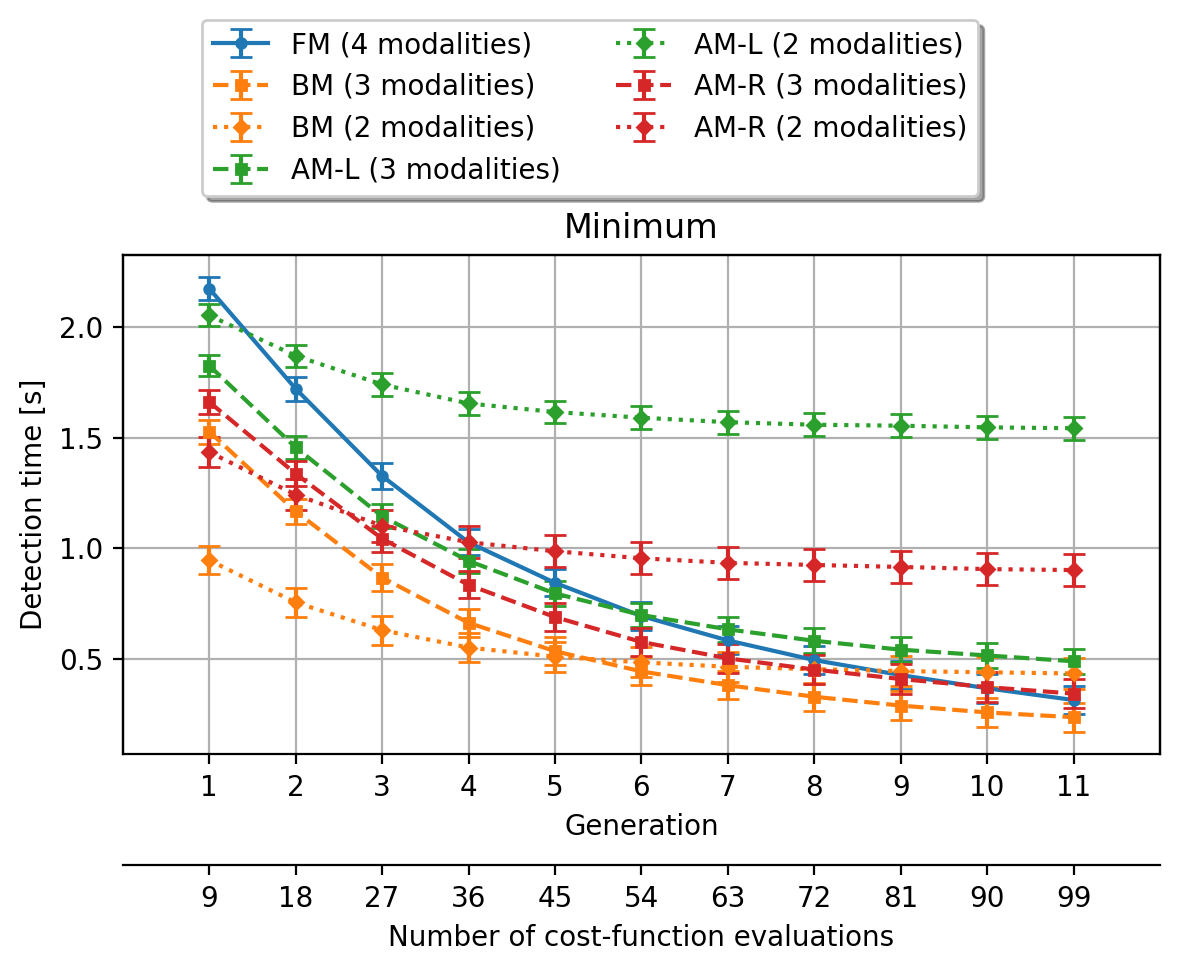

In [69]:
keys = [*data_mean]
fig, ax = plt.subplots()
newax = ax.twiny()
fig.subplots_adjust(bottom=0.20)
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.xaxis.set_ticks_position('bottom')
newax.xaxis.set_label_position('bottom')
newax.spines['bottom'].set_position(('outward', 40))
for key in keys:
    plot_results_min(data_min[key], label=report_labels(key, lang='EN'), ax=ax, fig=fig, ylabel="Detection time [s]", 
                     n_gen=11, marker=get_marker_from_key(key), error=True, color=cycle[get_color_idx_from_key(key)],
                    linestyle=get_linestyle_from_key(key), lang='EN', newax=newax)

        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.22), shadow=True, ncol=2)

plt.tight_layout()
fig_folder = os.path.join("figures", "level_selection_study")
fname = os.path.join(fig_folder, "lvl_sel_sim_unp_all.pdf")
plt.savefig(fname, bbox_inches="tight") 

Perform statistical tests to determine if difference between curves at a given generation is significant.

In [70]:
n_gen = 11
names = ["Initial 4 levels",
        "Model 3 levels", "Loudness 3 levels", "Roughness 3 levels",
        "Model 2 levels", "Loudness 2 levels", "Roughness 2 levels"]
dd = {"Gen": range(1, n_gen+1)}

for name in names:
    data = np.asarray(data_min[name])
    p_val = []
    for gen in range(n_gen):
        _, p = shapiro(data[:, gen])
        p_val.append(p)
    dd[name] = p_val
    
df_p = pd.DataFrame(dd)

In [71]:
df_p.style.applymap(alpha_bold)

,Gen,Initial 4 levels,Model 3 levels,Loudness 3 levels,Roughness 3 levels,Model 2 levels,Loudness 2 levels,Roughness 2 levels
0,1,0.000021,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.000014,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


None of the datapoints can be considered normally distributed, so a non parametric test should be used to to test the differences between means.
We use a Mann-Whitney U test

In [72]:
n_gen = 11
names = ["Initial 4 levels",
        "Model 3 levels", "Loudness 3 levels", "Roughness 3 levels",
        "Model 2 levels", "Loudness 2 levels", "Roughness 2 levels"]

btd = []
wtd = []
df = {}
for gen in range(n_gen):
    for name in names:
        gen_data = np.asarray(data_min[name])[:, gen]
        df[name] = gen_data

    p_df_btd = get_better_than_p_vals(pd.DataFrame(df), "Initial 4 levels", "less", bonf=False)
    p_df_wtd = get_better_than_p_vals(pd.DataFrame(df), "Initial 4 levels", "greater", bonf=False)
    
    
    btd.append(p_df_btd)
    wtd.append(p_df_wtd)

We look at the genarations at whic each methods results in better perfomances than the reference

In [73]:
full_dict = {}
for col_name in btd[0].columns:
    temp_dict = {col_name : [btd[idx][col_name][0] for idx in range(len(btd))]}
    full_dict.update(temp_dict)

dd_btd = pd.DataFrame.from_dict(full_dict) 

In [74]:
get_significance(dd_btd)

,Model 3 levels,Loudness 3 levels,Roughness 3 levels,Model 2 levels,Loudness 2 levels,Roughness 2 levels
0,***,***,***,***,***,***
1,***,***,***,***,NS,***
2,***,***,***,***,NS,***
3,***,*,*,***,NS,NS
4,***,*,NS,***,NS,NS
5,**,NS,NS,*,NS,NS
6,**,NS,NS,NS,NS,NS
7,*,NS,NS,NS,NS,NS
8,*,NS,NS,NS,NS,NS
9,NS,NS,NS,NS,NS,NS


Now we look at the generations where the reference gives better results than the tested methods

In [75]:
full_dict = {}
for col_name in btd[0].columns:
    temp_dict = {col_name : [wtd[idx][col_name][0] for idx in range(len(btd))]}
    full_dict.update(temp_dict)

dd_wtd = pd.DataFrame.from_dict(full_dict) 

In [76]:
get_significance(dd_wtd)

,Model 3 levels,Loudness 3 levels,Roughness 3 levels,Model 2 levels,Loudness 2 levels,Roughness 2 levels
0,NS,NS,NS,NS,NS,NS
1,NS,NS,NS,NS,NS,NS
2,NS,NS,NS,NS,***,NS
3,NS,NS,NS,NS,***,NS
4,NS,NS,NS,NS,***,NS
5,NS,NS,NS,NS,***,*
6,NS,NS,NS,NS,***,**
7,NS,NS,NS,NS,***,***
8,NS,NS,NS,NS,***,***
9,NS,NS,NS,NS,***,***


## Detectability N1 case

In [54]:
nb_runs = 50
sim_model = "DetLin"
pred_model = "DetLinExc"
n_tokeep_list = [4, 3, 2]

In [55]:
name_list = ["Initial", "Model", "dN Peak WB", "dFB-mel-pow-MAE"]
features_list = [None, pred_model, "dNpeak_BS", 'dFBmelpowfullMAEpos_S']
minmax_list = [None, "min", "min", "max", 'max']

Make simulations

In [57]:
data_min, data_mean = run_fifty_fifty_mean(sim_model, n_tokeep_list, nb_runs, features_list, name_list, minmax_list)

Features : None
N to keep:  4


100%|██████████| 28/28 [00:43<00:00,  1.54s/it]


Features : DetLinExc
N to keep:  3


100%|██████████| 28/28 [01:04<00:00,  2.29s/it]


N to keep:  2


100%|██████████| 28/28 [01:03<00:00,  2.28s/it]


Features : dNpeak_BS
N to keep:  3


100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


N to keep:  2


100%|██████████| 28/28 [00:45<00:00,  1.62s/it]


Features : dFBmelpowfullMAEpos_S
N to keep:  3


100%|██████████| 28/28 [00:45<00:00,  1.63s/it]


N to keep:  2


100%|██████████| 28/28 [00:45<00:00,  1.61s/it]


Save simulation data

In [58]:
with open(os.path.join(backup_folder, 'det_N1_mean_mean.pickle'), 'wb') as f:
    pickle.dump(data_mean, f)
with open(os.path.join(backup_folder, 'det_N1_min_mean.pickle'), 'wb') as f:
    pickle.dump(data_min, f)

Load simulation data

In [77]:
with open(os.path.join(backup_folder, 'det_N1_mean_mean.pickle'), 'rb') as f:
    data_mean = pickle.load(f)
with open(os.path.join(backup_folder, 'det_N1_min_mean.pickle'), 'rb') as f:
    data_min = pickle.load(f)

Plot

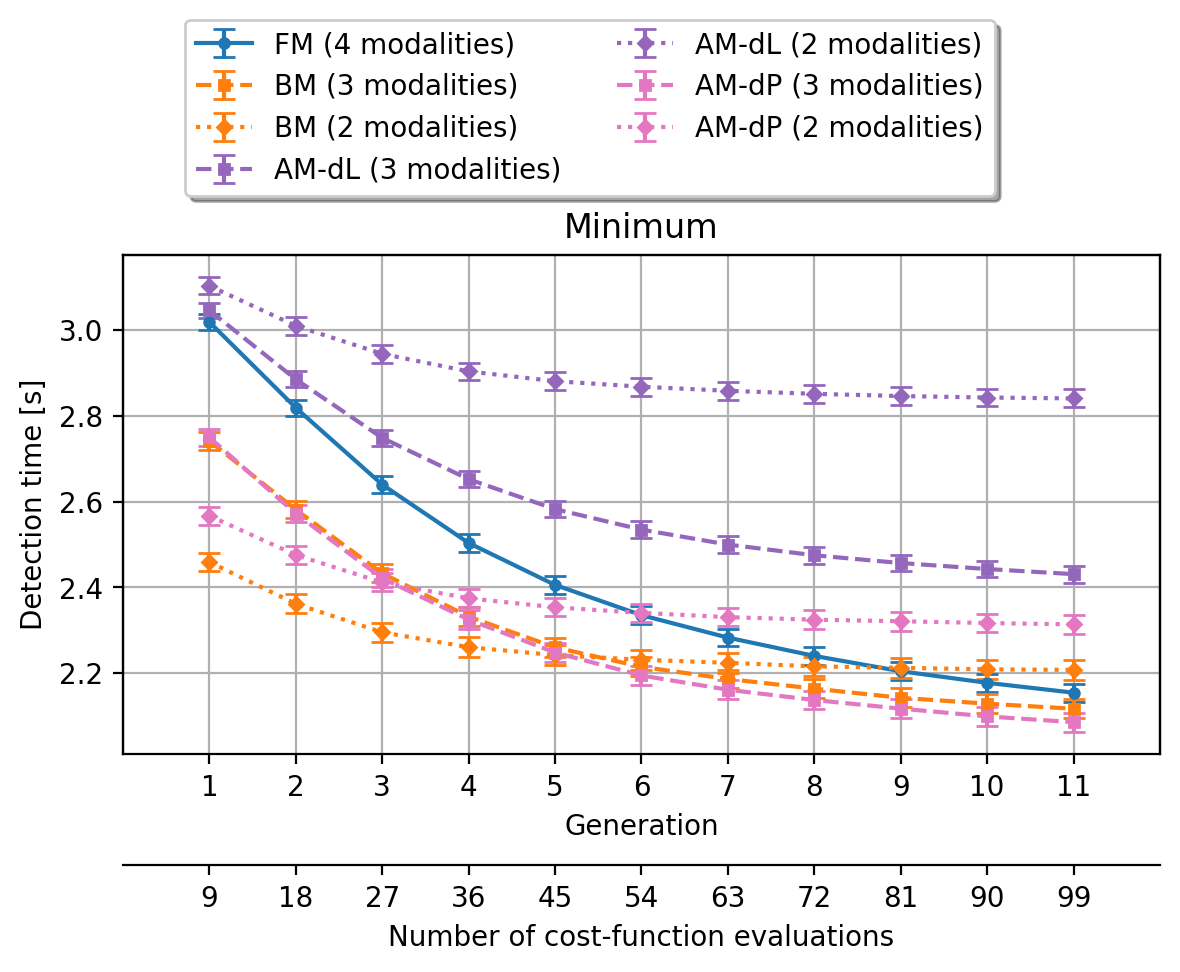

In [78]:
keys = [*data_mean]
fig, ax = plt.subplots()
newax = ax.twiny()
fig.subplots_adjust(bottom=0.20)
newax.set_frame_on(True)
newax.patch.set_visible(False)
newax.xaxis.set_ticks_position('bottom')
newax.xaxis.set_label_position('bottom')
newax.spines['bottom'].set_position(('outward', 40))
for key in keys:
    plot_results_min(data_min[key], label=report_labels(key, lang='EN'), ax=ax, fig=fig, ylabel="Detection time [s]", 
                     n_gen=11, marker=get_marker_from_key(key), error=True, color=cycle[get_color_idx_from_key(key)],
                    linestyle=get_linestyle_from_key(key), lang='EN', newax=newax)

        
handles, labels = ax.get_legend_handles_labels()
fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(0.5, 1.22), shadow=True, ncol=2)

plt.tight_layout()
fig_folder = os.path.join("figures", "level_selection_study")
fname = os.path.join(fig_folder, "lvl_sel_sim_det_all.pdf")
plt.savefig(fname, bbox_inches="tight") 

Perform statistical tests to determine if difference between curves at a given generation is significant.

In [79]:
n_gen = 11
names = ["Initial 4 levels",
        "Model 3 levels", "dN Peak WB 3 levels", "dFB-mel-pow-MAE 3 levels",
        "Model 2 levels", "dN Peak WB 2 levels", "dFB-mel-pow-MAE 2 levels"]
dd = {"Gen": range(1, n_gen+1)}

for name in names:
    data = np.asarray(data_min[name])
    p_val = []
    for gen in range(n_gen):
        _, p = shapiro(data[:, gen])#, alternative="greater")
        p_val.append(p)
    dd[name] = p_val
    
df_p = pd.DataFrame(dd)

In [80]:
df_p.style.applymap(alpha_bold)

,Gen,Initial 4 levels,Model 3 levels,dN Peak WB 3 levels,dFB-mel-pow-MAE 3 levels,Model 2 levels,dN Peak WB 2 levels,dFB-mel-pow-MAE 2 levels
0,1,0.000080,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,2,0.000001,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,5,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,6,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
6,7,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
7,8,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,9,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
9,10,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


None of the datapoints can be considered normally distributed, so a non parametric test should be used to to test the differences between means.

In [81]:
n_gen = 11
names = ["Initial 4 levels",
        "Model 3 levels", "dN Peak WB 3 levels", "dFB-mel-pow-MAE 3 levels",
        "Model 2 levels", "dN Peak WB 2 levels", "dFB-mel-pow-MAE 2 levels"]

btd = []
wtd = []
df = {}
for gen in range(n_gen):
    for name in names:
        gen_data = np.asarray(data_min[name])[:, gen]
        df[name] = gen_data

    p_df_btd = get_better_than_p_vals(pd.DataFrame(df), "Initial 4 levels", "less", bonf=False)
    p_df_wtd = get_better_than_p_vals(pd.DataFrame(df), "Initial 4 levels", "greater", bonf=False)
    
    btd.append(p_df_btd)
    wtd.append(p_df_wtd)

In [82]:
full_dict = {}
for col_name in btd[0].columns:
    temp_dict = {col_name : [btd[idx][col_name][0] for idx in range(len(btd))]}
    full_dict.update(temp_dict)

dd_btd = pd.DataFrame.from_dict(full_dict) 

In [83]:
get_significance(dd_btd)

,Model 3 levels,dN Peak WB 3 levels,dFB-mel-pow-MAE 3 levels,Model 2 levels,dN Peak WB 2 levels,dFB-mel-pow-MAE 2 levels
0,***,NS,***,***,NS,***
1,***,NS,***,***,NS,***
2,***,NS,***,***,NS,***
3,***,NS,***,***,NS,***
4,***,NS,***,***,NS,**
5,***,NS,***,***,NS,NS
6,***,NS,***,*,NS,NS
7,**,NS,***,NS,NS,NS
8,**,NS,***,NS,NS,NS
9,*,NS,**,NS,NS,NS


In [84]:
full_dict = {}
for col_name in btd[0].columns:
    temp_dict = {col_name : [wtd[idx][col_name][0] for idx in range(len(btd))]}
    full_dict.update(temp_dict)

dd_wtd = pd.DataFrame.from_dict(full_dict) 

In [85]:
get_significance(dd_wtd)

,Model 3 levels,dN Peak WB 3 levels,dFB-mel-pow-MAE 3 levels,Model 2 levels,dN Peak WB 2 levels,dFB-mel-pow-MAE 2 levels
0,NS,NS,NS,NS,***,NS
1,NS,**,NS,NS,***,NS
2,NS,***,NS,NS,***,NS
3,NS,***,NS,NS,***,NS
4,NS,***,NS,NS,***,NS
5,NS,***,NS,NS,***,NS
6,NS,***,NS,NS,***,NS
7,NS,***,NS,NS,***,*
8,NS,***,NS,NS,***,***
9,NS,***,NS,NS,***,***
